In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f38eb9dec50>)

In [ ]:
# 데이터 불러오기
test_data = pd.read_table('ratings_total.txt', header=None)

test_data.head(5)

,0,1
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [ ]:
# 헤더가 없으므로 헤더 추가
test_data.columns = ['star', 'reviews']

test_data.head(5)

,star,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [ ]:
# 개수 확인
test_data.shape

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   star     200000 non-null  int64 
 1   reviews  200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [ ]:
# 중복제거
test_data = test_data.drop_duplicates(subset=['reviews'])

test_data.shape

(199908, 2)

In [ ]:
# Nan 값 제거
test_data = test_data.dropna(how='any')

test_data.shape

(199908, 2)

In [ ]:
# 한글만 추출
test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

test_data['reviews'].head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0                                              배공빠르고 굿
1                        택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2    아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3    선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4                    민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
Name: reviews, dtype: object

In [ ]:
x_test = test_data['reviews']
# 별 1, 2은 부정(0), 별 4, 5는 긍정(1)으로 분류한다.
# 이것은 평가가 좋냐 나쁘냐로 단순화하여 알아보기 위함이다. 
y_test = test_data.replace({'star':[1, 2]}, 0)
y_test = y_test.replace({'star':[4, 5]}, 1)
y_test = y_test['star']
print(y_test)

0         1
1         0
2         1
3         0
4         1
         ..
199995    0
199996    1
199997    1
199998    1
199999    1
Name: star, Length: 199908, dtype: int64


In [ ]:
# 훈련 데이터는 네이버 영화 평점으로 훈련한다.
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test# test

('ratings.txt', <http.client.HTTPMessage at 0x7f38e8542790>)

In [ ]:
train_data = pd.read_table('ratings.txt')

train_data.head(5)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
# 훈련 데이터도 정제한다.
train_data = train_data.drop_duplicates(subset=['document'])
train_data = train_data.dropna(how='any')
train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

x_train = train_data['document']
y_train = train_data['label']
print(len(train_data), len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


194543 199908


## 3. 토큰화 (sentencepiece활용)

In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm
temp_file = 'ratings.txt' # 네이버 영화리뷰 감성분석의 'document'컬럼을 txt로 만들고 input파일로 넣으세요.

vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
# model type : unigram , bpe, char, word

## 4. 인코딩 및 패딩설정

In [ ]:
def sp_tokenize(s, corpus):
    # sp_tokenize 함수 내에서 각 라인이 어떤일을 하는지 '자세히'주석을 달아주세요.

    tensor = [] # 텐서

    for sen in corpus: # 한 문장씩 분리하여 
        tensor.append(s.EncodeAsIds(sen)) # 텐서에 문장을 ids집합으로 토큰화하여 추가한다.

    with open("./korean_spm.vocab", 'r') as f: #korean_spm.vocab 파일을 한 줄씩 읽는다.
        vocab = f.readlines() #

    word_index = {} # 단어 중심
    index_word = {} # index 중심

    for idx, line in enumerate(vocab): # vocab 1줄씩 풀어서 idx와 문장으로 가져온다.
        word = line.split("\t")[0] # tab 기준으로 단어를 분리한다.

        word_index.update({idx:word}) #index와 단어를 추가
        index_word.update({word:idx}) #단어와 index를 추가

    # 배열 크기를 맞추기 위하여, 나머지 부분은 패딩을 post, 즉 뒤에 0으로 채워넣는다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') 

    return tensor, word_index, index_word

In [ ]:
# train하고 test를 sp_tokenizer를 통과해주세요
sp = spm.SentencePieceProcessor()
sp.Load('korean_spm.model')

x_train_tensor, x_train_word_to_index, x_train_index_to_word = sp_tokenize(sp, x_train)
x_test_tensor, x_test_word_to_index, x_test_index_to_word = sp_tokenize(sp, x_test)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train_tensor)

(194543,) (194543,)
(199908,) (199908,)
[[2144  223  305 ...    0    0    0]
 [ 877 6431 2759 ...    0    0    0]
 [3791  821  768 ...    0    0    0]
 ...
 [ 277 6307    6 ...    0    0    0]
 [ 119 6519  198 ...    0    0    0]
 [ 432 6930 6513 ...    0    0    0]]


## 6. 모델 설계

In [ ]:
vocab_size = 8000
word_vector_dim = 128

In [ ]:
"""
LSTM (장단기 메모리 셀) 기본 구조
데이터의 장기간 의존성을 위해 사용
TimeDistributed : 입력 층의 모든 time step에 (...)의 내용을 적용 => 각 time step을 별개의 샘플로 다룰 때 효과적
"""
""" 강사님 조언 1: 일단 잘 나왔다는 평가. 보통 acc가 0.5로 나옴.
차이가 나는 경우라면, loss 그래프일 경우를 말하고, validation loss와 training loss가 차이가 많이 날 경우, 
중간에 early stopping을 걸어서 중단해주시면 됩니다. (training loss는 0으로 수렴하고, validation loss는 발산할경우
"""

# 16s 41ms/step - loss: 0.1107 - accuracy: 0.9628 - val_loss: 1.0763 - val_accuracy: 0.7226
model = keras.Sequential(name = 'LSTM_custom')
model.add(
    keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
)
model.add(keras.layers.LSTM(20, return_sequences=True))
model.add(keras.layers.TimeDistributed(tf.keras.layers.Dense(10)))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.LSTM(16, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(16, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# loss: 0.1513 - accuracy: 0.9393 - val_loss: 0.8253 - val_accuracy: 0.7
# model.add(keras.layers.LSTM(128, return_sequences = True))
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(keras.layers.LSTM(64, return_sequences = True))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(64, activation='relu'))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.LSTM(16, return_sequences = True))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(1, activation='sigmoid'))


#loss: 0.2462 - accuracy: 0.8955 - val_loss: 0.6105 - val_accuracy: 0.
# model = keras.Sequential(name = 'LSTM')
# model.add(
#     keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
# )
# model.add(keras.layers.LSTM(32, return_sequences = True))
# model.add(keras.layers.Dense(32, activation='relu'))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.LSTM(32, return_sequences = True))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(1, activation='sigmoid'))

# model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1024000   
                                                                 
 lstm (LSTM)                 (None, None, 20)          11920     
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          5504      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense_1 (Dense)             (None, None, 16)          528       
                                                              

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
epochs = 50
history = model.fit(x_train_tensor, y_train, epochs = epochs, batch_size=512, validation_data=(x_test_tensor, y_test), verbose=1 )

Epoch 1/50
380/380 [==============================] - 24s 44ms/step - loss: 0.5710 - accuracy: 0.7264 - val_loss: 0.6677 - val_accuracy: 0.6461
Epoch 2/50
380/380 [==============================] - 15s 40ms/step - loss: 0.6347 - accuracy: 0.6044 - val_loss: 0.6928 - val_accuracy: 0.5129
Epoch 3/50
380/380 [==============================] - 17s 44ms/step - loss: 0.6412 - accuracy: 0.6092 - val_loss: 0.6789 - val_accuracy: 0.5904
Epoch 4/50
380/380 [==============================] - 15s 40ms/step - loss: 0.5226 - accuracy: 0.7704 - val_loss: 0.7098 - val_accuracy: 0.5876
Epoch 5/50
380/380 [==============================] - 16s 43ms/step - loss: 0.5291 - accuracy: 0.7553 - val_loss: 0.6598 - val_accuracy: 0.6409
Epoch 6/50
380/380 [==============================] - 15s 40ms/step - loss: 0.4499 - accuracy: 0.8027 - val_loss: 0.6146 - val_accuracy: 0.6957
Epoch 7/50
380/380 [==============================] - 17s 44ms/step - loss: 0.4278 - accuracy: 0.8126 - val_loss: 0.6490 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


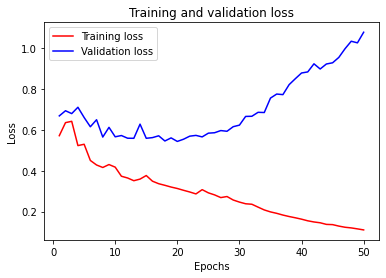

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

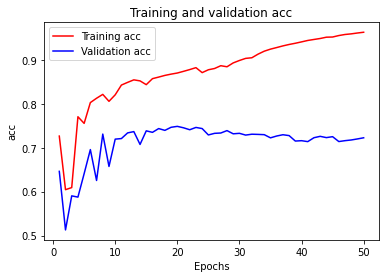

In [ ]:
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()